In [122]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from tracr.rasp import rasp
from tracr.compiler import compiling, rasp_to_graph
import numpy as np
from tracr.compiler.validating import validate
from typing import Union, TypeVar
from lauro_inverse_tracr import map_primitives

## Proposal for program generation

In [2]:
# RASP instructions:
# - Map
# - SequenceMap
# - LinearSequenceMap (compiled exactly into MLP weights)
# - Select
# - Aggregate
# - SelectorWidth

# One way to do things is to sample realistic transformers:
# ie sample MLP, attn, MLP, attn, etc
# - MLP can be one of Map, SequenceMap, LinearSequenceMap
# - attn can be one of (Select, Aggregate) or (Select, SelectorWidth)

# The other way to do it is to just sample any reasonable RASP program.
# That way we generalize better to example programs that don't follor the 
# transformer pattern.
# But what does 'reasonable RASP program' mean?

# - it follows the Tracr constraints so it compiles correctly
# - it has a reasonable number of instructions
# - it doesn't do anything trivial (eg return a constant)
# - it uses comparisons when appropriate (eg don't < compare two strings)

In [3]:
# 1) sample MLP layer
# 2) sample attn layer


# within a program, keep track of scope and distinguish between
# categorical and numerical variables.
# maybe: also distinguish 'boolean' variables (numerical and only 0,1)

In [4]:
class EmptyScopeError(Exception):
    pass


def annotate_type(sop: rasp.SOp, type: str):
    """Annotate a SOp with a type."""
    # important for compiler:
    if type in ["bool", "float"]:
        sop = rasp.numerical(sop)
    elif type in ["categorical"]:
        sop = rasp.categorical(sop)
    else:
        raise ValueError(f"Unknown type {type}.")
    
    # ignored by compiler but used by program sampler:
    sop = rasp.annotate(sop, type=type)
    return sop


def filter_scope(variable_scope: list, type: str):
    """Return the subset of variables that are of a given type."""
    filtered = [v for v in variable_scope if v.annotations["type"] == type]
    if len(filtered) == 0:
        raise EmptyScopeError(f"No variables of type {type} in scope.")
    return filtered


def sample_map(variable_scope: list):
    """Sample a map. A map applies a function elementwise to a SOp.
    The input SOps can be categorical, float, or bool."""
    arg = np.random.choice(variable_scope)
    fn, output_type = map_primitives.get_map_fn(arg)
    output_sop = rasp.Map(fn, arg)
    output_sop = annotate_type(output_sop, type=output_type)
    return output_sop


def sample_sequence_map(variable_scope: list):
    """Sample a sequence map. A SM applies a function elementwise to
    two categorical SOps."""
    raise NotImplementedError()
#    args = np.random.choice(categorical_scope(variable_scope), size=2, replace=False)
#    return rasp.SequenceMap(fn, *args)


def sample_linear_sequence_map(variable_scope: list):
    """Sample a linear sequence map. A LNS linearly combines two
    numerical SOps."""
    raise NotImplementedError()
#    args = np.random.choice(numerical_scope(variable_scope), size=2, replace=False)
#    weights = np.random.normal(size=2)
#    return rasp.numerical(rasp.LinearSequenceMap(*args, *weights))


def sample_selector(variable_scope: list):
    """Sample a rasp.Select. A select takes two categorical SOps and
    returns a selector (matrix) of booleans."""
    args = np.random.choice(filter_scope(variable_scope, type="categorical"), size=2, replace=True)
    comparison = np.random.choice(map_primitives.COMPARISONS)
    return rasp.Select(*args, comparison)


def sample_aggregate(variable_scope: list, selector):
    """
    Tracr puts constraints on select-aggregate operations:
    1) If selector has width >1, then sop_arg must be 'boolean',
    that is numerical and only takes values 0 or 1.
    2) If selector has width 1, then sop_arg can be anything.
    """
    # for now just use boolean SOPs.
    sop_arg = np.random.choice(filter_scope(variable_scope, type="bool"))
    aggr = rasp.Aggregate(selector, sop_arg, default=0)
    aggr = annotate_type(aggr, type="float")  # has to be numerical (tracr constraint)
    return aggr


def get_selector_width(selector):
    sop = rasp.SelectorWidth(selector)
    return annotate_type(sop, type="categorical")


def validate_custom_types(expr: rasp.SOp, test_input: list = [1,2,3,4,5]):
    out = expr(test_input)
    if expr.annotations["type"] == "bool":
        # bools are numerical and only take values 0 or 1
        if not np.all(np.isin(out, [0,1])):
            raise ValueError(f"Bool SOps may only take values 0 or 1. Instead, received {out}")
        elif not rasp.numerical(expr):
            raise ValueError(f"Bool SOps must be numerical. Instead, {expr} is categorical.")
    elif expr.annotations["type"] == "float":
        # floats are numerical and can take any value
        if not rasp.numerical(expr):
            raise ValueError(f"Float SOps must be numerical. Instead, {expr} is categorical.")
    elif expr.annotations["type"] == "categorical":
        if not rasp.categorical(expr):
            raise ValueError(f"{expr} is annotated as type=categorical, but is actually numerical.")

In [112]:
class ProgramSampler:
    def __init__(self):
        self.sops = [rasp.tokens, rasp.indices]
        self.sops = [annotate_type(sop, type="categorical") for sop in self.sops]

    def sample(self, n_layers=3):
        """Sample a program."""
        for _ in range(n_layers):
            self.sample_mlp()
            self.sample_attention()
        self.output = self.sops[-1]
        self.validate()

    def sample_mlp(self):
        """Add an MLP layer to the program."""
        output_sop = np.random.choice([
            sample_map(self.sops),
#            sample_sequence_map(self.sops),
#            sample_linear_sequence_map(self.sop),
        ])
        self.sops.append(output_sop)
        return

    def sample_attention(self):
        """Add an attention layer to the program."""
        selector = sample_selector(self.sops)
        try:
            output_sop = np.random.choice([
                sample_aggregate(self.sops, selector),
#                get_selector_width(selector),
            ])
        except EmptyScopeError:
            print("No boolean variables in scope, so using SelectorWidth.")
            output_sop = get_selector_width(selector)
        self.sops.append(output_sop)
        return
    
    def validate(self):
        """Validate the program."""
        for sop in self.sops:
            validate_custom_types(sop)
            errs = validate(sop, [1,2,3,4,5])
            if errs:
                raise ValueError(f"Invalid program: {errs}")
            return

In [118]:
sampler = ProgramSampler()
sampler.sample()
print(sampler.output([1,2,3,4]))

[1.5, 2.0, 2.5, 3.0]


In [124]:
graph = rasp_to_graph.extract_rasp_graph(sampler.output)
sorted_nodes = nx.topological_sort(graph.graph)

['tokens', 'indices', 'select_2', 'map_3', 'aggregate_1']


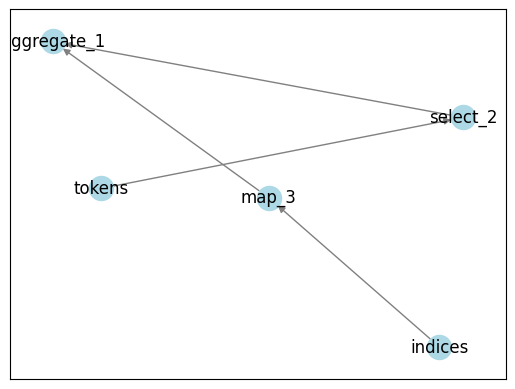

In [131]:
import networkx as nx
nx.draw_networkx(graph.graph, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)

In [184]:
graph.graph.nodes['aggregate_1']

{'ID': 'aggregate_1', 'EXPR': <tracr.rasp.rasp.Aggregate at 0x7f554cfd1240>}